# Image Inferential Statistics

Inferential Statistics for pixel values

### import packages

In [1]:
import pickle
import json

import numpy as np
import pandas as pd

import cv2
from skimage import filters
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from tqdm.notebook import tqdm

### import image settings

In [2]:
with open('../data/interim/im_dims.json', 'r') as fp:
    dim_dict = json.load(fp)

new_n_rows = dim_dict['new_n_rows']
new_n_cols = dim_dict['new_n_cols']

### compute t and wilcoxon

In [3]:
def make_stat(diff_data, n_data):
    
    t, tp = stats.ttest_1samp(diff_data, 0, alternative='two-sided')
    w, wp = stats.wilcoxon(diff_data, alternative='two-sided', zero_method='zsplit')

    avg = diff_data.mean().values
    n = (abs(diff_data)>0).sum().values # this is not valid for the difference or for clean, because the difference can be zero when both the full and masked condition have non-zero data!
    
    sample = (abs(diff_data)>0).count().values
    
    d = {'t': t,
         'tp': tp,
         'w': w,
         'wp': wp,
         'pixel n': n,
         'n df': n_data.values,
         'mean': avg,
         'sample n': sample
        }
    
    return d

In [4]:
def make_emos_stat(emo1, emo2, cond, comparison):
    
    big_flat_df = pd.read_csv(f'../data/processed/big_{cond}_{comparison}_df.tsv', sep='\t', index_col=[0, 1, 2])
    n_flat_df = pd.read_csv(f'../data/processed/n_{cond}_{comparison}_df.tsv', sep='\t', index_col=[0, 1])

    diff_data = big_flat_df.loc[(emo1, emo2), :]
    n_data = n_flat_df.loc[(emo1, emo2), :]
    
    return make_stat(diff_data, n_data)

Example:

In [5]:
example_d = make_emos_stat('Angry', 'Disgusted', 'Full', 'baseline')
example_df = pd.DataFrame(example_d).T
example_df

0      1      2      3      4      5      6      7      8      \
t           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
tp          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
w         280.5  280.5  280.5  280.5  280.5  280.5  280.5  280.5  280.5   
wp          1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
pixel n     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
n df        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
mean        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
sample n   33.0   33.0   33.0   33.0   33.0   33.0   33.0   33.0   33.0   

          9      ...  26921  26922  26923  26924  26925  26926  26927  26928  \
t           NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
tp          NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
w         280.5  ...  280.5  280.5  280.5  280.5  280.5  280.5  280.5  280.5   
wp          1.0  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
pixel n     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
n df        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
mean        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
sample n   33.0  ...   33.0   33.0   33.0   33.0   33.0   33.0   33.0   33.0   

          26929  26930  
t           NaN    NaN  
tp          NaN    NaN  
w         280.5  280.5  
wp          1.0    1.0  
pixel n     0.0    0.0  
n df        0.0    0.0  
mean        0.0    0.0  
sample n   33.0   33.0  

[8 rows x 26931 columns]

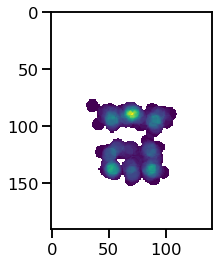

In [6]:
im = example_df.loc['t', :].values.reshape(new_n_rows, new_n_cols)
plt.imshow(im)

## compare raw data against zero

In [7]:
def make_stat_base_df(cond, comparison):
    
    stat_df = pd.DataFrame()

    big_flat_df = pd.read_csv(f'../data/processed/big_{cond}_{comparison}_df.tsv', sep='\t', index_col=[0, 1, 2])

    try:
        emos1 = big_flat_df.index.levels[0].drop('Mean')
    except:
        emos1 = big_flat_df.index.levels[0]
    
    for emo1 in tqdm(emos1, leave=False):      
        this_emo = big_flat_df.loc[emo1, :]
        
        emos2 = this_emo.index.remove_unused_levels().levels[0]
        for emo2 in tqdm(emos2, leave=False):

            this_d = make_emos_stat(emo1, emo2, cond, comparison)
    
            this_df = pd.DataFrame(this_d).T
            this_df.index = pd.MultiIndex.from_tuples([(emo1, emo2, i) for i in this_df.index])
            
            stat_df = pd.concat([stat_df, this_df])
            
    return stat_df

### for all conditions

In [8]:
comparisons = ['baseline', 'clean', 'confusions']
comparisons

['baseline', 'clean', 'confusions']

In [9]:
conds = ['Full', 'Upper', 'Lower', 'Full_gr_Upper', 'Full_gr_Lower']
conds

['Full', 'Upper', 'Lower', 'Full_gr_Upper', 'Full_gr_Lower']

In [ ]:
for comparison in tqdm(comparisons):

    for cond in tqdm(conds, leave=False):
        try:
            baseline_stat_df = make_stat_base_df(cond, comparison)
            baseline_stat_df.to_csv(f'../data/processed/stat_{cond}_{comparison}_df.tsv', sep='\t')
        except:
            pass

### Example Plot

In [12]:
def example_plot(df, emo1, emo2, new_n_rows=new_n_rows, new_n_cols=new_n_cols):

    fig = plt.figure(figsize=(16, 4))

    my_stats = df.index.levels[2]
    
    for n, my_stat in enumerate(my_stats):

        ax = plt.subplot(1, len(my_stats), n+1)

        im = df.loc[(emo1, emo2, my_stat)].values.reshape(new_n_rows, new_n_cols)
        imax = ax.imshow(im)
        plt.colorbar(imax, fraction=0.07)
        ax.set_title(my_stat)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
    return

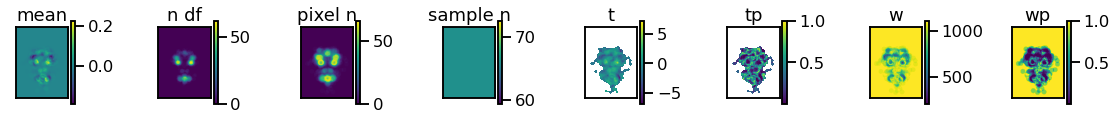

In [13]:
example_plot(baseline_stat_df, 'Surprised', 'Fearful')